#install important packages

In [201]:
pip install tensorflow sklearn pandas numpy matplotlib nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#import python packages

In [202]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D

#Read dataset as json file

In [203]:
with open("Intent.json") as diabetes_dataset:
  dataset = json.load(diabetes_dataset)

In [204]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [205]:
[tags, inputs, responses] = processing_json_dataset(dataset)

#dataset as DataFrame

In [206]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [207]:
dataset.head()

,inputs,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting


In [208]:
dataset = dataset.sample(frac=1)

In [209]:
dataset.head()

,inputs,tags
4,Hello there,Greeting
23,Good thanks! This is Adam,CourtesyGreetingResponse
93,"Thank you, bye",CourtesyGoodBye
68,Wasn't communicating to you,NotTalking2U
120,Make me laugh,Jokes


#Pre-processing text of dataset

In [210]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [211]:
dataset.head()

,inputs,tags
4,"[h, e, l, l, o, , t, h, e, r, e]",Greeting
23,"[g, o, o, d, , t, h, a, n, k, s, , t, h, i, ...",CourtesyGreetingResponse
93,"[t, h, a, n, k, , y, o, u, , b, y, e]",CourtesyGoodBye
68,"[w, a, s, n, t, , c, o, m, m, u, n, i, c, a, ...",NotTalking2U
120,"[m, a, k, e, , m, e, , l, a, u, g, h]",Jokes


In [212]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [213]:
dataset.head()

,inputs,tags
4,hello there,Greeting
23,good thanks this is adam,CourtesyGreetingResponse
93,thank you bye,CourtesyGoodBye
68,wasnt communicating to you,NotTalking2U
120,make me laugh,Jokes


In [214]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [215]:
len(features[0])

9

In [216]:
input_shape = features.shape[1]
print(input_shape)

9


In [217]:
features.shape

(143, 9)

In [218]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  117
output length:  22


In [219]:
tokenizer.word_index

{'a': 16,
 'about': 114,
 'adam': 20,
 'adios': 84,
 'am': 12,
 'any': 49,
 'anyone': 75,
 'are': 4,
 'aware': 73,
 'bay': 18,
 'be': 67,
 'bella': 21,
 'bored': 105,
 'by': 87,
 'bye': 41,
 'call': 36,
 'camera': 77,
 'can': 10,
 'cheering': 113,
 'clever': 52,
 'communicating': 81,
 'comprendo': 110,
 'conscious': 56,
 'could': 91,
 'do': 9,
 'doing': 59,
 'door': 19,
 'enough': 93,
 'for': 51,
 'friends': 95,
 'fuck': 70,
 'genious': 74,
 'get': 107,
 'girl': 53,
 'give': 104,
 'good': 34,
 'goodbye': 46,
 'gossip': 33,
 'got': 108,
 'great': 43,
 'have': 55,
 'hear': 101,
 'hello': 38,
 'help': 90,
 'helpful': 97,
 'hi': 57,
 'hola': 79,
 'hope': 71,
 'how': 30,
 'hya': 64,
 'i': 5,
 'identify': 99,
 'in': 76,
 'intelligent': 66,
 'is': 2,
 'it': 31,
 'joke': 58,
 'jokes': 85,
 'know': 35,
 'later': 103,
 'laugh': 83,
 'make': 82,
 'me': 3,
 'mean': 88,
 'meant': 117,
 'more': 109,
 'my': 28,
 'name': 11,
 'need': 112,
 'not': 25,
 'off': 94,
 'ok': 50,
 'open': 22,
 'please': 13,


#RNN MODEL

## Build RNN Model

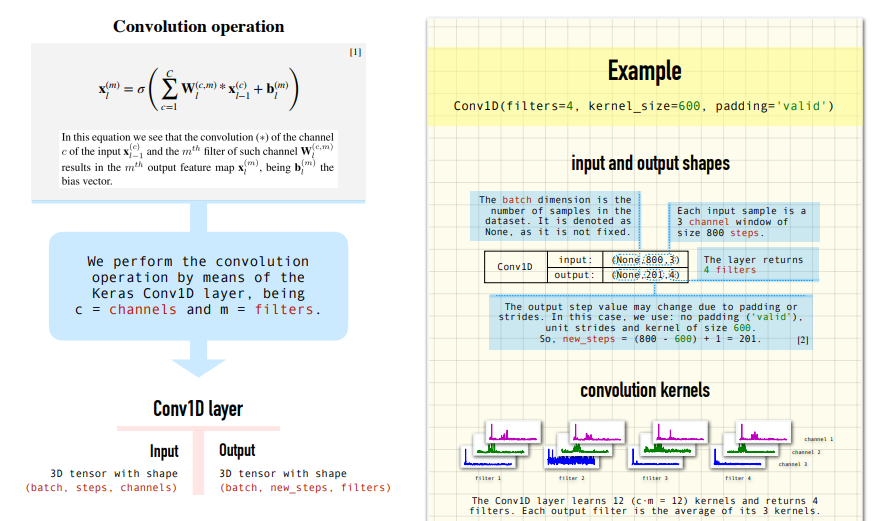

In [220]:
m = Sequential()
m.add(Input(shape=(features.shape[1])))
m.add(Embedding(vocabulary + 1,100))
m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))

In [39]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-07-05 13:12:37--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-05 13:12:37--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.50MB/s    in 4m 32s  

2022-07-05 13:17:09 (3.03 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [221]:
m.layers

In [153]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [222]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [223]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [224]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False

In [225]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [226]:
m.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 9, 100)            11800     
                                                                 
 conv1d_16 (Conv1D)          (None, 5, 32)             16032     
                                                                 
 dropout_59 (Dropout)        (None, 5, 32)             0         
                                                                 
 lstm_16 (LSTM)              (None, 5, 32)             8320      
                                                                 
 lstm_17 (LSTM)              (None, 16)                3136      
                                                                 
 dense_38 (Dense)            (None, 128)               2176      
                                                                 
 dropout_60 (Dropout)        (None, 128)             

In [227]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 400, mode = 'min', restore_best_weights = True)

In [228]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

Epoch 1/2000
3/3 [==============================] - 4s 17ms/step - loss: 3.0984 - accuracy: 0.0140
Epoch 2/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.0887 - accuracy: 0.0699
Epoch 3/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.0886 - accuracy: 0.0490
Epoch 4/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.0834 - accuracy: 0.0699
Epoch 5/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.0705 - accuracy: 0.0490
Epoch 6/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.0706 - accuracy: 0.1049
Epoch 7/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.0599 - accuracy: 0.1049
Epoch 8/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.0556 - accuracy: 0.1189
Epoch 9/2000
3/3 [==============================] - 0s 15ms/step - loss: 3.0472 - accuracy: 0.1189
Epoch 10/2000
3/3 [==============================] - 0s 14ms/step - loss: 3.0415 - accuracy: 0.0769
Epoch 11/

In [229]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

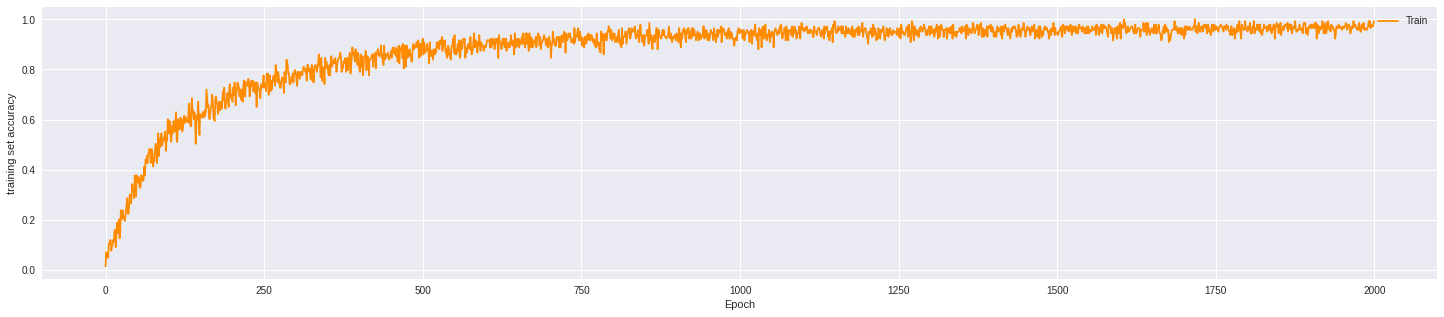

In [230]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

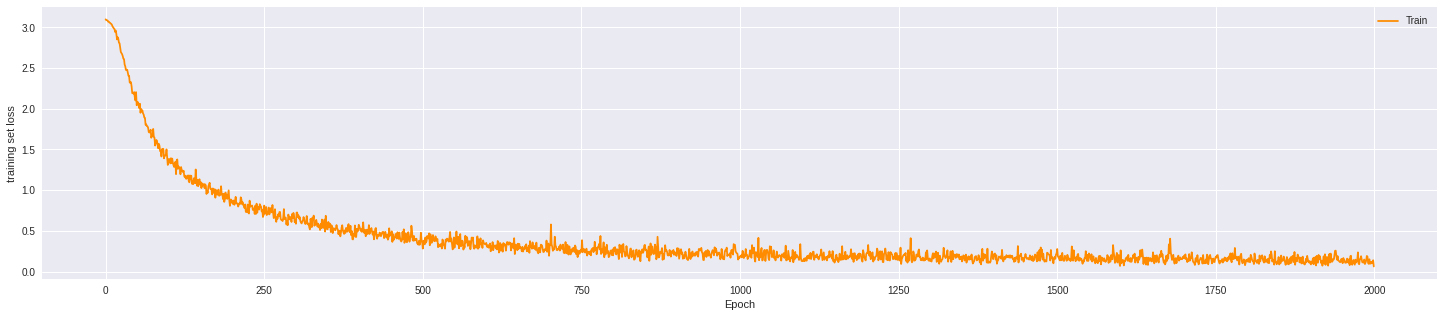

In [231]:
draw_plot(history_training.history['loss'],'training set loss' )

In [232]:
m.evaluate(features, labels, batch_size = 64)

3/3 [==============================] - 1s 6ms/step - loss: 0.0440 - accuracy: 0.9930


[0.04396675527095795, 0.9930070042610168]

#Live Testing

In [233]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  output = output.argmax()
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag])

In [238]:
list_que = ["hello", "i am kaled","what is my name?",
            "what is your name?", "tell me please, what is your name?"]
for i in list_que:
  print("you: {}".format(i))
  res_tag = generate_answer(i)
  print(res_tag)  

you: hello
Hola human, please tell me your GeniSys user
you: i am kaled
Good! Hi <HUMAN>, how can I help you?
you: what is my name?
<HUMAN>, what can I do for you?
you: what is your name?
You may call me Geni
you: tell me please, what is your name?
You may call me Geni
